# IMPORTING LIBRARIES

In [10]:
import os
import pandas as pd
import numpy as np

In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

In [4]:
from spotipy import oauth2
import random
from functools import reduce

# ACCESSING MY ACCOUNT

In [65]:
cid = '84a918187a0d4fc5a66dd8e062fff899'
secret = '9f4fea70be164dd7bb5ffcf653b33d29'
redirect_uri='http://localhost:8080/callback/'
username = 'egtrwnupl4nlhpsxae4aecqno'

In [66]:
scope = 'playlist-modify-public'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

# COLLECTING DATA FROM SPOTIFY API

In [16]:
# create empty lists where the results are going to be stored
artist_name = []
track_name = []
popularity = []
artist_id=[]
track_id = []


## SPOTIFY ALLOWS US TO ACCESS ONLY 1000 ELEMENTS
for i in range(0,1000,50):
    track_results = sp.search(q='year:2021', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        artist_id.append(t['artists'][0]['id'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
      


In [17]:
print('number of elements in the track_id list:', len(track_id))


number of elements in the track_id list: 1000


In [18]:


df_tracks = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'artist_id': artist_id,'popularity':popularity})
print(df_tracks.shape)
df_tracks.head()

(1000, 5)


artist_name                    track_name                track_id  \
0              LISA                         MONEY  45OX2jjEw1l7lOFJfDP9fv   
1         Anuv Jain                           Gul  0NLkVxf0PyxsXBG3EuZcJf   
2     Pratsofficial  Aziyat 2.0 - Reprise Version  3fwyItGexa88kR8j76dIqv   
3   Stephen Sanchez             Until I Found You  0T5iIrXA4p5GsubkhuBIKV   
4  Sachet-Parampara  Maiyya Mainu (From "Jersey")  4PwTeFfKqmR3XIeXXUBDOf   

                artist_id  popularity  
0  5L1lO4eRHmJ7a0Q6csE5cT          78  
1  4gdMJYnopf2nEUcanAwstx          71  
2  29ggvWc5EMcSk5RLQ5aXHr          73  
3  5XKFrudbV4IiuE5WuTPRmT          89  
4  1SyKki7JI1AZNKwgNMkn25          78

In [20]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist_name  1000 non-null   object
 1   track_name   1000 non-null   object
 2   track_id     1000 non-null   object
 3   artist_id    1000 non-null   object
 4   popularity   1000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


In [47]:
grouped = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
grouped[grouped > 1].count()

18

# INFORMATION ABOUT ARTISTS

In [19]:
artist_popularity = []
artist_genres = []
artist_followers = []
for a_id in df_tracks.artist_id:
  artist = sp.artist(a_id)
  artist_popularity.append(artist['popularity'])
  artist_genres.append(artist['genres'])
  artist_followers.append(artist['followers']['total'])

In [22]:
df_tracks = df_tracks.assign(artist_popularity=artist_popularity, artist_genres=artist_genres, artist_followers=artist_followers)
df_tracks.head()

artist_name                    track_name                track_id  \
0              LISA                         MONEY  45OX2jjEw1l7lOFJfDP9fv   
1         Anuv Jain                           Gul  0NLkVxf0PyxsXBG3EuZcJf   
2     Pratsofficial  Aziyat 2.0 - Reprise Version  3fwyItGexa88kR8j76dIqv   
3   Stephen Sanchez             Until I Found You  0T5iIrXA4p5GsubkhuBIKV   
4  Sachet-Parampara  Maiyya Mainu (From "Jersey")  4PwTeFfKqmR3XIeXXUBDOf   

                artist_id  popularity  artist_popularity  \
0  5L1lO4eRHmJ7a0Q6csE5cT          78                 71   
1  4gdMJYnopf2nEUcanAwstx          71                 66   
2  29ggvWc5EMcSk5RLQ5aXHr          73                 58   
3  5XKFrudbV4IiuE5WuTPRmT          89                 76   
4  1SyKki7JI1AZNKwgNMkn25          78                 66   

                                       artist_genres  artist_followers  
0                                            [k-pop]           3742659  
1  [hindi indie, indian indie, indian singer-song...            402668  
2        [desi pop, himachali pop, modern bollywood]             37654  
3                     [gen z singer-songwriter, pop]            261293  
4                       [desi pop, modern bollywood]            285498

# DROPPING DUPLICATE DATA FROM

In [48]:
df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace=True)

In [49]:
# doing the same grouping as before to verify the solution
grouped_after_dropping = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
grouped_after_dropping[grouped_after_dropping > 1].count()

0

In [50]:
df_tracks[df_tracks.duplicated(subset=['artist_name','track_name'],keep=False)].count()

artist_name    0
track_name     0
track_id       0
popularity     0
dtype: int64

In [51]:
df_tracks.shape

(982, 4)

# TRACKS' NUMERICAL FEATURES

In [26]:
# empty list, batchsize and the counter for None results
rows = []
batchsize = 100
None_counter = 0

for i in range(0,len(df_tracks['track_id']),batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t == None:
            None_counter = None_counter + 1
        else:
            rows.append(t)
            
print('Number of tracks where no audio features were available:',None_counter)


Number of tracks where no audio features were available: 1


In [27]:
print('number of elements in the track_id list:', len(rows))

number of elements in the track_id list: 999


In [31]:
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
print("Shape of the dataset:", df_audio_features.shape)
df_audio_features.head()

Shape of the dataset: (999, 18)


danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.826   0.553    1   -10.121     0       0.2340         0.163   
1         0.600   0.294    6   -12.301     1       0.0292         0.871   
2         0.445   0.280   10   -12.668     1       0.0275         0.819   
3         0.539   0.508   10    -6.050     1       0.0288         0.727   
4         0.630   0.739    0    -3.942     1       0.0248         0.194   

   instrumentalness  liveness  valence    tempo            type  \
0          0.000041     0.135    0.400  140.037  audio_features   
1          0.000087     0.102    0.342   86.970  audio_features   
2          0.000013     0.111    0.299  104.743  audio_features   
3          0.000000     0.174    0.227  101.358  audio_features   
4          0.000000     0.113    0.224  109.985  audio_features   

                       id                                   uri  \
0  45OX2jjEw1l7lOFJfDP9fv  spotify:track:45OX2jjEw1l7lOFJfDP9fv   
1  0NLkVxf0PyxsXBG3EuZcJf  spotify:track:0NLkVxf0PyxsXBG3EuZcJf   
2  3fwyItGexa88kR8j76dIqv  spotify:track:3fwyItGexa88kR8j76dIqv   
3  0T5iIrXA4p5GsubkhuBIKV  spotify:track:0T5iIrXA4p5GsubkhuBIKV   
4  4PwTeFfKqmR3XIeXXUBDOf  spotify:track:4PwTeFfKqmR3XIeXXUBDOf   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/45OX2jjEw1l7...   
1  https://api.spotify.com/v1/tracks/0NLkVxf0Pyxs...   
2  https://api.spotify.com/v1/tracks/3fwyItGexa88...   
3  https://api.spotify.com/v1/tracks/0T5iIrXA4p5G...   
4  https://api.spotify.com/v1/tracks/4PwTeFfKqmR3...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/45OX...       168228   
1  https://api.spotify.com/v1/audio-analysis/0NLk...       217241   
2  https://api.spotify.com/v1/audio-analysis/3fwy...       194286   
3  https://api.spotify.com/v1/audio-analysis/0T5i...       177720   
4  https://api.spotify.com/v1/audio-analysis/4PwT...       231576   

   time_signature  
0               4  
1               4  
2               4  
3               3  
4               4

In [32]:
df_audio_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      999 non-null    float64
 1   energy            999 non-null    float64
 2   key               999 non-null    int64  
 3   loudness          999 non-null    float64
 4   mode              999 non-null    int64  
 5   speechiness       999 non-null    float64
 6   acousticness      999 non-null    float64
 7   instrumentalness  999 non-null    float64
 8   liveness          999 non-null    float64
 9   valence           999 non-null    float64
 10  tempo             999 non-null    float64
 11  type              999 non-null    object 
 12  id                999 non-null    object 
 13  uri               999 non-null    object 
 14  track_href        999 non-null    object 
 15  analysis_url      999 non-null    object 
 16  duration_ms       999 non-null    int64  
 1

In [56]:
columns_to_drop = ['analysis_url','track_href','type','uri']
df_audio_features.drop(columns_to_drop, axis=1,inplace=True)

df_audio_features.rename(columns={'id': 'track_id'}, inplace=True)

df_audio_features.shape

(981, 14)

In [46]:
df_audio_features.rename(columns={'id': 'track_id'}, inplace=True)

In [41]:
df_audio_features.info()
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      999 non-null    float64
 1   energy            999 non-null    float64
 2   loudness          999 non-null    float64
 3   speechiness       999 non-null    float64
 4   acousticness      999 non-null    float64
 5   instrumentalness  999 non-null    float64
 6   liveness          999 non-null    float64
 7   valence           999 non-null    float64
 8   tempo             999 non-null    float64
 9   id                999 non-null    object 
 10  duration_ms       999 non-null    int64  
 11  time_signature    999 non-null    int64  
dtypes: float64(9), int64(2), object(1)
memory usage: 93.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------           

In [43]:
df_tracks['artist_name'] = df_tracks['artist_name'].astype("string")
df_tracks['track_name'] = df_tracks['track_name'].astype("string")
df_tracks['track_id'] = df_tracks['track_id'].astype("string")
df_tracks['artist_id'] = df_tracks['artist_id'].astype("string")
df_audio_features['duration_ms'] = pd.to_numeric(df_audio_features['duration_ms'])
df_audio_features['instrumentalness'] = pd.to_numeric(df_audio_features['instrumentalness'])
df_audio_features['time_signature'] = df_audio_features['time_signature'].astype("category")
print(df_tracks.info())
print(df_audio_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   artist_name        1000 non-null   string
 1   track_name         1000 non-null   string
 2   track_id           1000 non-null   string
 3   artist_id          1000 non-null   string
 4   popularity         1000 non-null   int64 
 5   artist_popularity  1000 non-null   int64 
 6   artist_genres      1000 non-null   object
 7   artist_followers   1000 non-null   int64 
dtypes: int64(3), object(1), string(4)
memory usage: 62.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   danceability      999 non-null    float64 
 1   energy            999 non-null    float64 
 2   loudness          999 non-null    float64 
 3   speechin

In [47]:
# merge both dataframes
# the 'inner' method will make sure that we only keep track IDs present in both datasets
df = pd.merge(df_tracks,df_audio_features)#,on='track_id',how='inner')
print("Shape of the dataset:", df_audio_features.shape)
df.head()

Shape of the dataset: (999, 12)


artist_name                    track_name                track_id  \
0              LISA                         MONEY  45OX2jjEw1l7lOFJfDP9fv   
1         Anuv Jain                           Gul  0NLkVxf0PyxsXBG3EuZcJf   
2     Pratsofficial  Aziyat 2.0 - Reprise Version  3fwyItGexa88kR8j76dIqv   
3   Stephen Sanchez             Until I Found You  0T5iIrXA4p5GsubkhuBIKV   
4  Sachet-Parampara  Maiyya Mainu (From "Jersey")  4PwTeFfKqmR3XIeXXUBDOf   

                artist_id  popularity  artist_popularity  \
0  5L1lO4eRHmJ7a0Q6csE5cT          78                 71   
1  4gdMJYnopf2nEUcanAwstx          71                 66   
2  29ggvWc5EMcSk5RLQ5aXHr          73                 58   
3  5XKFrudbV4IiuE5WuTPRmT          89                 76   
4  1SyKki7JI1AZNKwgNMkn25          78                 66   

                                       artist_genres  artist_followers  \
0                                            [k-pop]           3742659   
1  [hindi indie, indian indie, indian singer-song...            402668   
2        [desi pop, himachali pop, modern bollywood]             37654   
3                     [gen z singer-songwriter, pop]            261293   
4                       [desi pop, modern bollywood]            285498   

   danceability  energy  loudness  speechiness  acousticness  \
0         0.826   0.553   -10.121       0.2340         0.163   
1         0.600   0.294   -12.301       0.0292         0.871   
2         0.445   0.280   -12.668       0.0275         0.819   
3         0.539   0.508    -6.050       0.0288         0.727   
4         0.630   0.739    -3.942       0.0248         0.194   

   instrumentalness  liveness  valence    tempo  duration_ms time_signature  
0          0.000041     0.135    0.400  140.037       168228              4  
1          0.000087     0.102    0.342   86.970       217241              4  
2          0.000013     0.111    0.299  104.743       194286              4  
3          0.000000     0.174    0.227  101.358       177720              3  
4          0.000000     0.113    0.224  109.985       231576              4

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 980
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       981 non-null    object 
 1   track_name        981 non-null    object 
 2   track_id          981 non-null    object 
 3   popularity        981 non-null    int64  
 4   danceability      981 non-null    float64
 5   energy            981 non-null    float64
 6   key               981 non-null    int64  
 7   loudness          981 non-null    float64
 8   mode              981 non-null    int64  
 9   speechiness       981 non-null    float64
 10  acousticness      981 non-null    float64
 11  instrumentalness  981 non-null    float64
 12  liveness          981 non-null    float64
 13  valence           981 non-null    float64
 14  tempo             981 non-null    float64
 15  duration_ms       981 non-null    int64  
 16  time_signature    981 non-null    int64  
dt

In [48]:
#Just in case, checking for any duplicate tracks:
df[df.duplicated(subset=['artist_name','track_name'],keep=False)]

artist_name                                track_name  \
12   The Kid LAROI                 STAY (with Justin Bieber)   
13   Justin Bieber                                     Ghost   
20       Lil Nas X         INDUSTRY BABY (feat. Jack Harlow)   
44   The Kid LAROI                 STAY (with Justin Bieber)   
83       Lil Nas X            MONTERO (Call Me By Your Name)   
133          Spice  Go Down Deh (feat. Shaggy and Sean Paul)   
155            Nej                                      Paro   
162      Lil Nas X            MONTERO (Call Me By Your Name)   
167    Masked Wolf                    Astronaut In The Ocean   
179      Lil Nas X         INDUSTRY BABY (feat. Jack Harlow)   
207       Coldplay                               My Universe   
270       Coldplay                               My Universe   
300  Justin Bieber                                   Hold On   
303         Zaeden                                     KTMBK   
310       Doja Cat                  Kiss Me More (feat. SZA)   
341          Spice  Go Down Deh (feat. Shaggy and Sean Paul)   
365  Justin Bieber                                     Ghost   
400       NAALAYAK                                     Zakir   
402  Justin Bieber                                   Hold On   
417       Doja Cat                  Kiss Me More (feat. SZA)   
467           King                        Desi Dan Bilzerian   
500   Taylor Swift             Love Story (Taylor’s Version)   
501          Adele                                Easy On Me   
551     Elton John                   Cold Heart - PNAU Remix   
565     Elton John                   Cold Heart - PNAU Remix   
588    Masked Wolf                    Astronaut In The Ocean   
605  Justin Bieber                                    Anyone   
607  Justin Bieber                                    Anyone   
627            Nej                                      Paro   
680   Taylor Swift             Love Story (Taylor’s Version)   
709          Adele                                Easy On Me   
710    OneRepublic                                       Run   
825    OneRepublic                                       Run   
854       NAALAYAK                                     Zakir   
949         Zaeden                                     KTMBK   
960           King                        Desi Dan Bilzerian   
962        Kehlani                                   Gangsta   
964        Kehlani                                   Gangsta   

                   track_id               artist_id  popularity  \
12   5HCyWlXZPP0y6Gqq8TgA20  2tIP7SsRs7vjIcLrU85W8J          88   
13   6I3mqTwhRpn34SLVafSH7G  1uNFoZAHBGtllmzznpCI3s          88   
20   27NovPIUIRrOZoCHxABJwK  7jVv8c5Fj3E9VhNjxT4snq          85   
44   5PjdY0CKGZdEuoNab3yDmX  2tIP7SsRs7vjIcLrU85W8J          86   
83   1SC5rEoYDGUK4NfG82494W  7jVv8c5Fj3E9VhNjxT4snq          82   
133  0VzBKgimNRMauaqzT2rEnS  0wEvWMQRqaXcgnrZv6KtyL          73   
155  6zvHwijlnwqjS6d46yAffi  3BQ9mWlgFRfMr5EdNfc10a          75   
162  67BtfxlNbhBmCDR2L2l8qd  7jVv8c5Fj3E9VhNjxT4snq          78   
167  3Ofmpyhv5UAQ70mENzB277  1uU7g3DNSbsu0QjSEqZtEd          78   
179  5Z9KJZvQzH6PFmb8SNkxuk  7jVv8c5Fj3E9VhNjxT4snq          81   
207  3FeVmId7tL5YN8B7R3imoM  4gzpq5DPGxSnKTe4SA8HAU          84   
270  46HNZY1i7O6jwTA7Slo2PI  4gzpq5DPGxSnKTe4SA8HAU          81   
300  1nahzW3kfMuwReTka28tH5  1uNFoZAHBGtllmzznpCI3s          78   
303  4R8VBRb5nKbEfi1EIA2B7p  5lMNphVhMLvhFmTWiKiLA2          59   
310  748mdHapucXQri7IAO8yFK  5cj0lLjcoR7YOSnhnX0Po5          81   
341  58dGRQrNmAJeRMFuguUbvD  0wEvWMQRqaXcgnrZv6KtyL          69   
365  5dPz35akJjPqb17yeqNwqH  1uNFoZAHBGtllmzznpCI3s          80   
400  6RtnuC14DOUrvpRgS6WMQX  6BWd8VpOoODhMOPks4sI6R          57   
402  4u4NyuceXP7Uzh7XFJKCr1  1uNFoZAHBGtllmzznpCI3s          75   
417  3DarAbFujv6eYNliUTyqtz  5cj0lLjcoR7YOSnhnX0Po5          81   
467  5vdWj5rEzg9lg5qbE98PmX  5NHm4TU5Twz7owibYxJfFU          56   
500  3CeCwYWvdfXbZLXFhBrbnf  06HL4z0

In [51]:
# The most popular tracks of 2021
df.sort_values(by=['popularity'], ascending=False)[['track_name', 'artist_name']].head(20)


track_name       artist_name
65                                             Sunroof       Nicky Youre
3                                    Until I Found You   Stephen Sanchez
12                           STAY (with Justin Bieber)     The Kid LAROI
33                                               Woman          Doja Cat
100                                            traitor    Olivia Rodrigo
377                                  Where Are You Now  Lost Frequencies
13                                               Ghost     Justin Bieber
150                                  Happier Than Ever     Billie Eilish
66                                          Bad Habits        Ed Sheeran
101                                            deja vu    Olivia Rodrigo
171                                            Shivers        Ed Sheeran
53                                     drivers license    Olivia Rodrigo
104                                           good 4 u    Olivia Rodrigo
551                            Cold Heart - PNAU Remix        Elton John
89   Enemy (with JID) - from the series Arcane Leag...   Imagine Dragons
59                                   THATS WHAT I WANT         Lil Nas X
44                           STAY (with Justin Bieber)     The Kid LAROI
765                                              Pepas           Farruko
507                                             Freaks        Surf Curse
54                                             abcdefu             GAYLE

In [53]:
#Most followed artist
by_art_fol = pd.DataFrame(df.sort_values(by=['artist_followers'], ascending=False)[['artist_followers','artist_popularity', 'artist_name','artist_genres']])
by_art_fol.astype(str).drop_duplicates().head(20)

artist_followers artist_popularity      artist_name  \
904        103886909                91       Ed Sheeran   
304         70469286                89    Billie Eilish   
428         67940172                95            Drake   
365         66698299                91    Justin Bieber   
770         60875047                88     Arijit Singh   
557         60644358                99     Taylor Swift   
658         56190015                92              BTS   
701         51215861                94       The Weeknd   
411         43809074                88       Bruno Mars   
709         43156557                85            Adele   
282         42700471                89  Imagine Dragons   
211         39579574                85     Shawn Mendes   
207         39188195                89         Coldplay   
611         38483398                89      Post Malone   
461         38274758                76      Neha Kakkar   
84          38266644                86         Maroon 5   
554         37940216                84     Selena Gomez   
438         35629528                81      Alan Walker   
666         35571602                88         J Balvin   
202         34424738                84       Marshmello   

                                         artist_genres  
904                                  ['pop', 'uk pop']  
304                   ['art pop', 'electropop', 'pop']  
428  ['canadian hip hop', 'canadian pop', 'hip hop'...  
365                            ['canadian pop', 'pop']  
770          ['desi pop', 'filmi', 'modern bollywood']  
557                                            ['pop']  
658                       ['k-pop', 'k-pop boy group']  
701  ['canadian contemporary r&b', 'canadian pop', ...  
411                               ['dance pop', 'pop']  
709      ['british soul', 'pop', 'pop soul', 'uk pop']  
282                            ['modern rock', 'rock']  
211  ['canadian pop', 'dance pop', 'pop', 'viral pop']  
207                          ['permanent wave', 'pop']  
611                  ['dfw rap', 'melodic rap', 'rap']  
461          ['desi pop', 'filmi', 'modern bollywood']  
84                                             ['pop']  
554              ['dance pop', 'pop', 'post-teen pop']  
438                                  ['electro house']  
666  ['reggaeton', 'reggaeton colombiano', 'trap la...  
202  ['brostep', 'dance pop', 'edm', 'pop', 'pop da...

In [54]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
to_1D(df['artist_genres']).value_counts().head(20)

desi pop             360
filmi                198
modern bollywood     188
punjabi pop          163
desi hip hop         136
pop                  110
tamil pop             54
punjabi hip hop       46
dance pop             35
indian lo-fi          32
pakistani hip hop     30
tollywood             29
mollywood             27
haryanvi pop          23
k-pop                 23
canadian pop          21
desi trap             20
hindi indie           20
hindi hip hop         18
uk pop                18
dtype: int64

Text(0.5, 1.0, 'Top genres')

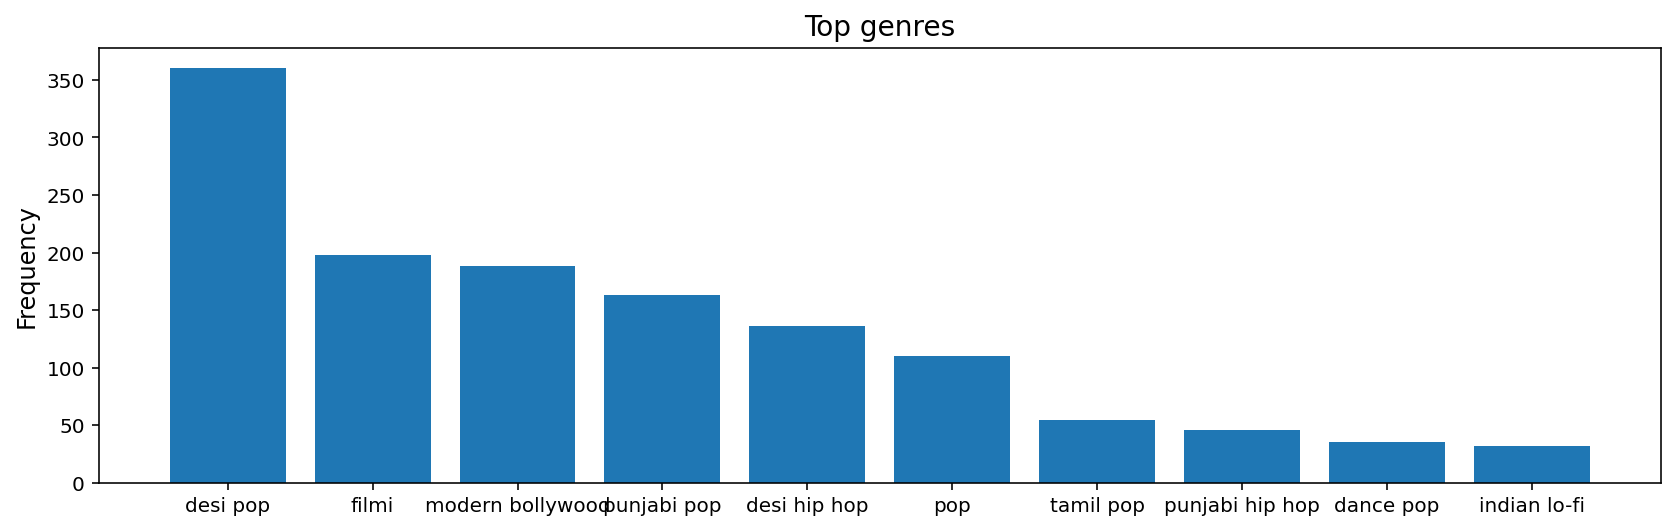

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (14,4))
ax.bar(to_1D(df['artist_genres']).value_counts().index[:10],
        to_1D(df['artist_genres']).value_counts().values[:10])
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Top genres", size = 14)

In [56]:
#top 20 artists sorted by the number of followers for each of top 10 genres
top_10_genres = list(to_1D(df['artist_genres']).value_counts().index[:20])
top_artists_by_genre = []
for genre in top_10_genres:
    for index, row in by_art_fol.iterrows():
    if genre in row['artist_genres']:
      top_artists_by_genre.append({'artist_name':row['artist_name'], 'artist_genre':genre})
      break
pd.json_normalize(top_artists_by_genre)

artist_name       artist_genre
0         Arijit Singh           desi pop
1         Arijit Singh              filmi
2         Arijit Singh   modern bollywood
3       Diljit Dosanjh        punjabi pop
4              Badshah       desi hip hop
5           Ed Sheeran                pop
6   Yuvan Shankar Raja          tamil pop
7     Sidhu Moose Wala    punjabi hip hop
8           Bruno Mars          dance pop
9             Swattrex       indian lo-fi
10    Sidhu Moose Wala  pakistani hip hop
11     Devi Sri Prasad          tollywood
12       K. J. Yesudas          mollywood
13             Badshah       haryanvi pop
14                 BTS              k-pop
15               Drake       canadian pop
16             Badshah          desi trap
17              Ritviz        hindi indie
18   Yo Yo Honey Singh      hindi hip hop
19          Ed Sheeran             uk pop

In [61]:
# Top 20 tracks sorted by popularity for each of top 10 genres:
by_track_pop = pd.DataFrame(df.sort_values(by=['popularity'], ascending=False)[['popularity','track_name', 'artist_name','artist_genres', 'track_id']])
by_track_pop.astype(str).drop_duplicates().head(20)
top_songs_by_genre = []
for genre in top_10_genres:
  for index, row in by_track_pop.iterrows():
    if genre in row['artist_genres']:
      top_songs_by_genre.append({'track_name':row['track_name'], 'popularity':row['popularity'],'artist_name':row['artist_name'], 'artist_genre':genre})
      break
pd.json_normalize(top_songs_by_genre)


track_name  popularity            artist_name  \
0    Raataan Lambiyan (From "Shershaah")          78         Tanishk Bagchi   
1   Kaadhal En Kaviye - From "Salmon 3D"          77             Sid Sriram   
2    Raataan Lambiyan (From "Shershaah")          78         Tanishk Bagchi   
3                                 Insane          77             AP Dhillon   
4                                    295          78       Sidhu Moose Wala   
5                                Sunroof          91            Nicky Youre   
6                Adiye - From "Bachelor"          76     Dhibu Ninan Thomas   
7                              We Rollin          79                  Shubh   
8                                  Woman          88               Doja Cat   
9                      Saibo - Lofi Flip          72                  VIBIE   
10                                   295          78       Sidhu Moose Wala   
11   Bodhai Kaname - From "Oh Manapenne"          68  Vishal Chandrashekhar   
12                         Jupiter Mazha          66            Dhanwin K B   
13                                 Jugnu          74                Badshah   
14                   Permission to Dance          80                    BTS   
15                                 Ghost          88          Justin Bieber   
16                                 Jugnu          74                Badshah   
17                                   Gul          71              Anuv Jain   
18    Ghana Kasoota (feat. Surbhi Jyoti)          64                Raftaar   
19                            Bad Habits          88             Ed Sheeran   

         artist_genre  
0            desi pop  
1               filmi  
2    modern bollywood  
3         punjabi pop  
4        desi hip hop  
5                 pop  
6           tamil pop  
7     punjabi hip hop  
8           dance pop  
9        indian lo-fi  
10  pakistani hip hop  
11          tollywood  
12          mollywood  
13       haryanvi pop  
14              k-pop  
15       canadian pop  
16          desi trap  
17        hindi indie  
18      hindi hip hop  
19             uk pop

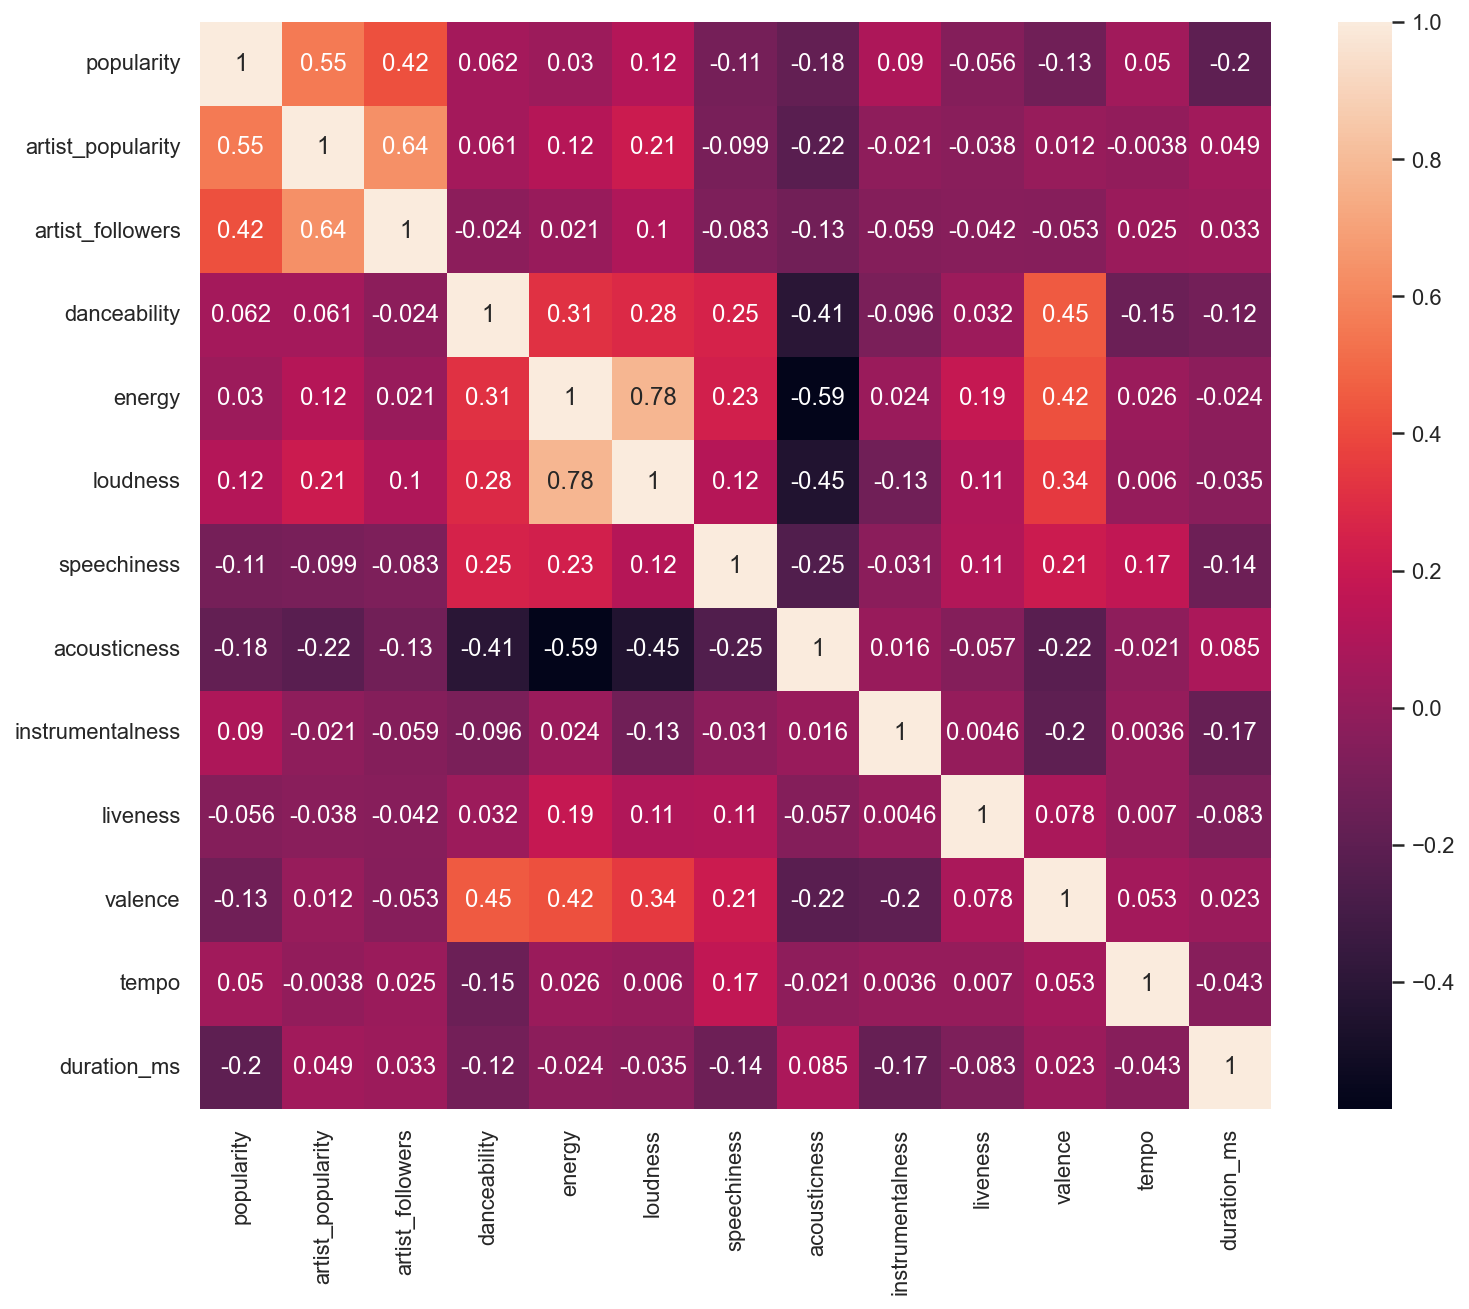

In [62]:
import seaborn as sn
sn.set(rc = {'figure.figsize':(12,10)})
sn.heatmap(df.corr(), annot=True)
plt.show()

<AxesSubplot:xlabel='energy', ylabel='loudness'>

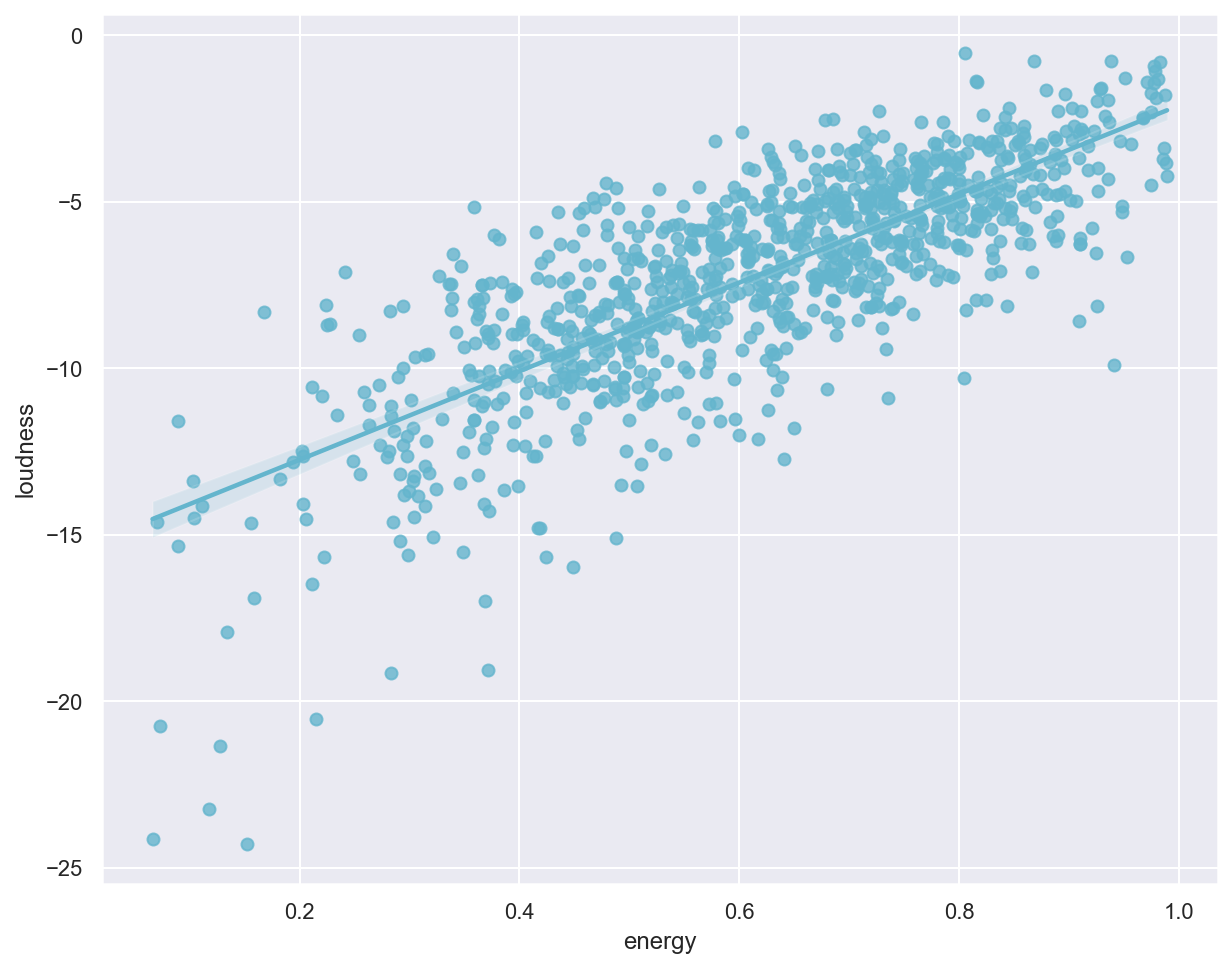

In [74]:
sn.set(rc = {'figure.figsize':(10,8)})
sn.regplot(data=df, y="loudness", x="energy",color='c')

<AxesSubplot:xlabel='acousticness', ylabel='popularity'>

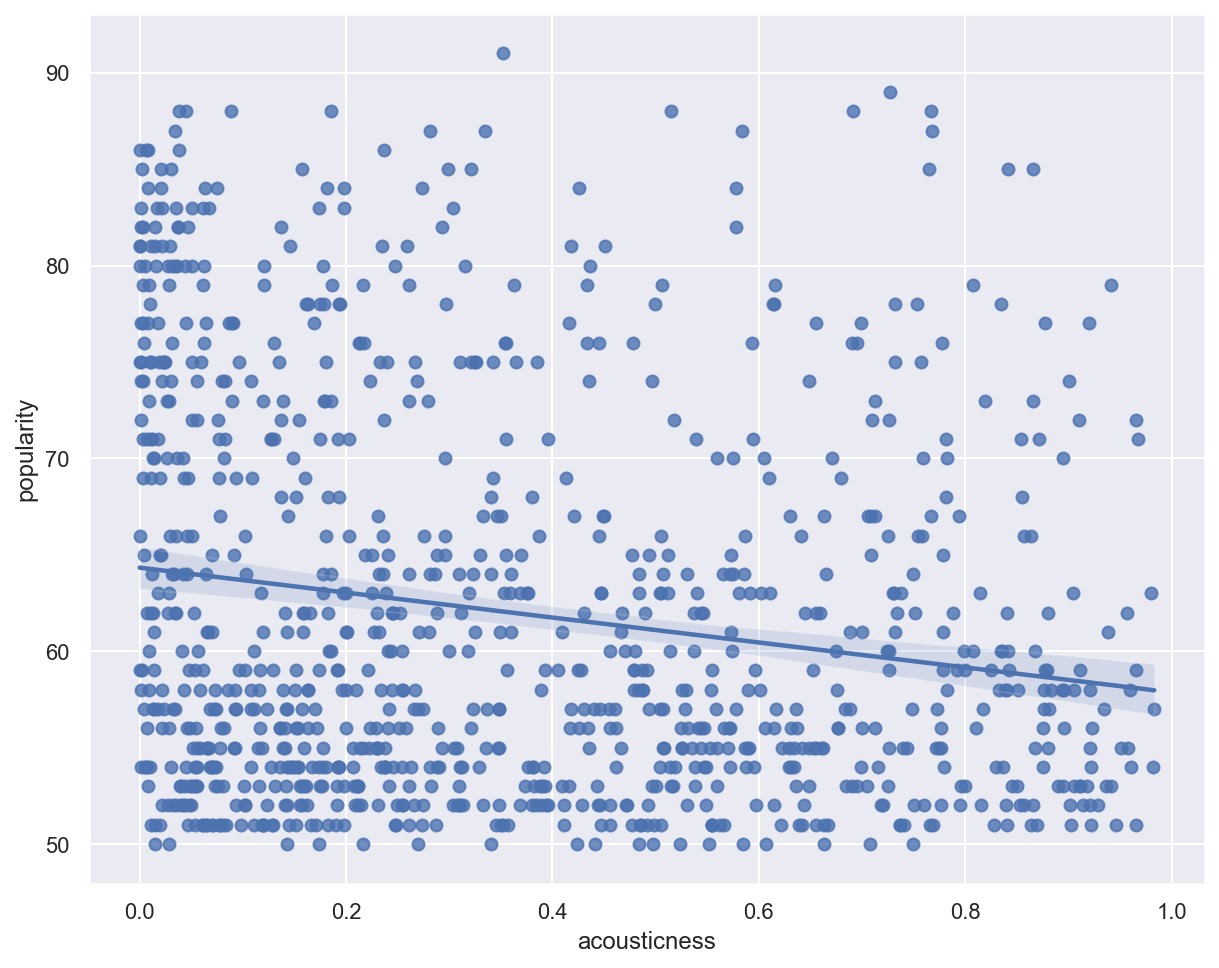

In [83]:
sn.set(rc = {'figure.figsize':(10,8)})
sn.regplot(data=df, y="popularity", x="acousticness",color='b')

In [68]:
#GETTING RECOMMENDATIONS

In [67]:
rec = sp.recommendations(seed_artists=["3PhoLpVuITZKcymswpck5b"], seed_genres=["pop"], seed_tracks=["1r9xUipOqoNwggBpENDsvJ"], limit=100)
for track in rec['tracks']:
  print(track['artists'][0]['name'], track['name'])

Coldplay My Universe - Galantis Remix
David Guetta Hey Mama (feat. Nicki Minaj, Bebe Rexha & Afrojack)
Rina Sawayama Chosen Family (with Elton John)
Imagine Dragons Mouth Of The River
Mike & The Mechanics The Living Years - 2019 Version
Michael McDonald Tears To Come
Paramore Grudges
Tony Bennett You're The Top
Imagine Dragons It's Time
Robin Schulz Sugar (feat. Francesco Yates) - Billions Club Remix
Jackson Browne Running on Empty
Bruno Mars Finesse - Remix; feat. Cardi B
Mark Ronson Uptown Funk (feat. Bruno Mars)
Gucci Mane Back on Road
Chris Rea I Can Hear Your Heartbeat
George Ezra Dance All Over Me - Jax Jones Remix
John Lennon Imagine - Ultimate Mix
Linkin Park In the End
Nicki Minaj Truffle Butter
Van Morrison Stage Name
Twenty One Pilots Migraine
DJ Khaled Shining (feat. Beyoncé & Jay-Z)
The Manhattan Transfer Scotch And Soda
Victor Crone Wind In My Sails
Snakehips Either Way (feat. Joey Bada$$)
DI-RECT Through The Looking Glass
Clean Bandit Tears (feat. Louisa Johnson)
Sia Che

In [71]:
#How are the most popular tracks different from all the tracks in the dataset?
feat_cols = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
top_100_feat = pd.DataFrame(columns=feat_cols)
for i, track in by_track_pop[:100].iterrows():
  features = df_audio_features[df_audio_features['track_id'] == track['track_id']]
  top_100_feat = top_100_feat.append(features, ignore_index=True)
top_100_feat = top_100_feat[feat_cols]

from sklearn import preprocessing
mean_vals = pd.DataFrame(columns=feat_cols)
mean_vals = mean_vals.append(top_100_feat.mean(), ignore_index=True)
mean_vals = mean_vals.append(df_audio_features[feat_cols].mean(), ignore_index=True)
print(mean_vals)

import plotly.graph_objects as go
import plotly.offline as pyo
fig = go.Figure(
    data=[
        go.Scatterpolar(r=mean_vals.iloc[0], theta=feat_cols, fill='toself', name='Top 100'),
        go.Scatterpolar(r=mean_vals.iloc[1], theta=feat_cols, fill='toself', name='All'),
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Feature comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

#pyo.plot(fig)
fig.show()




C:\Users\HP\AppData\Local\Temp\ipykernel_47980\1550543906.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_100_feat = top_100_feat.append(features, ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_47980\1550543906.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_100_feat = top_100_feat.append(features, ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_47980\1550543906.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_vals = mean_vals.append(top_100_feat.mean(), ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_47980\1550543906.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mean_

  danceability    energy speechiness acousticness instrumentalness  liveness  \
0       0.6648   0.64699    0.084499     0.213304         0.064084  0.172932   
1      0.65177  0.614431    0.103872     0.360921         0.024605  0.177391   

    valence  
0  0.469143  
1  0.516926  


In [49]:
df.to_csv('SpotifyAudioFeatures08082018.csv')

# Creating a playlist of my top 50 tracks using python


In [68]:
results = sp.current_user_top_tracks(limit=50, offset=0,time_range='medium_term')
results

{'items': [{'album': {'album_type': 'SINGLE',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4gdMJYnopf2nEUcanAwstx'},
      'href': 'https://api.spotify.com/v1/artists/4gdMJYnopf2nEUcanAwstx',
      'id': '4gdMJYnopf2nEUcanAwstx',
      'name': 'Anuv Jain',
      'type': 'artist',
      'uri': 'spotify:artist:4gdMJYnopf2nEUcanAwstx'}],
    'available_markets': ['AD',
     'AE',
     'AR',
     'AT',
     'AU',
     'BE',
     'BG',
     'BH',
     'BO',
     'BR',
     'CA',
     'CH',
     'CL',
     'CO',
     'CR',
     'CY',
     'CZ',
     'DE',
     'DK',
     'DO',
     'DZ',
     'EC',
     'EE',
     'EG',
     'ES',
     'FI',
     'FR',
     'GB',
     'GR',
     'GT',
     'HK',
     'HN',
     'HU',
     'ID',
     'IE',
     'IL',
     'IN',
     'IS',
     'IT',
     'JO',
     'JP',
     'KW',
     'LB',
     'LI',
     'LT',
     'LU',
     'LV',
     'MA',
     'MC',
     'MT',
     'MX',
     'MY',
     'NI',
     'NL',
     'NO',
   

In [69]:
track_name = []
track_id = []
artist = []
album = []
duration = []
popularity = []
for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

# Create the final df   
df_favourite = pd.DataFrame({ "track_name": track_name, 
                             "album": album, 
                             "track_id": track_id,
                             "artist": artist, 
                             "duration": duration, 
                             "popularity": popularity})

df_favourite

track_name  \
0                                          Baarishein   
1                                            Akhiyaan   
2                                                 Gul   
3                                              Tomboy   
4                                        Alag Aasmaan   
5                                  Yellow Paper Daisy   
6                                                 911   
7                                             Chidiya   
8                                         Tere Hi Hum   
9                                              Kasoor   
10                                   Walls Could Talk   
11                                         Dandelions   
12                                      Glimpse of Us   
13                                            vicious   
14                                            Matilda   
15                                    Sun Lo Na (Raw)   
16                                    Waqt Ki Baatein   
17                                        Sugar Daddy   
18                                   Watermelon Sugar   
19                                          telepatía   
20                                          positions   
21                                              Pause   
22                                          So Pretty   
23                                    Good In Goodbye   
24                       Music For a Sushi Restaurant   
25                                None Of My Business   
26                                              Drugs   
27                                            7 rings   
28                                         THAT BITCH   
29                                        i hate boys   
30                                    Love Of My Life   
31                                     Phir Miloge Na   
32                                    Pal Behta Jaaye   
33                                    Blinding Lights   
34                                     Therefore I Am   
35                   Let's Fall in Love for the Night   
36                                     Turn Back Time   
37                                          tere bina   
38                                               Baby   
39                                      Build a Bitch   
40                             Fuck Up The Friendship   
41                                      Orange Coffee   
42                    It Ain't Me (with Selena Gomez)   
43                                          Adore You   
44                                        double take   
45                                            Groupie   
46  MONTERO (Call Me By Your Name) - SATAN'S EXTEN...   
47                                  Aankhon Se Batana   
48                                            Perfect   
49                                If I Can't Have You   

                                      album                track_id  \
0                                Baarishein  5iCY0TXNImK4hyKfcplQsg   
1                                  Akhiyaan  2l3dFxtoSMgMQVyRIUHjpz   
2                                       Gul  0NLkVxf0PyxsXBG3EuZcJf   
3                                    Tomboy  5Ti3fqGTfjUsSdylFNy0Ng   
4                              Alag Aasmaan  74kCarkFBzXYXNkkYJIsG0   
5                        Yellow Paper Daisy  5aQe0faFOjeskrHwpleXLJ   
6                                   Chaotic  23KVefoON2iEz1dh940quQ   
7                                   Chidiya  7mNZUnDWUDidWBFaUpVtOC   
8                               Tere Hi Hum  1TkyDEdjiUuYhoMkxdZCiO   
9                                    Kasoor  08kTa3SL9sV6Iy8KLKtGql   
10       hopeless fountain kingdom (Deluxe)  5ln5yQdUywVbf8HhFsOcd6   
11                               Safe Haven  2eAvDnpXP5W0cVtiI0PUxV   
12                            Glimpse of Us  6xGruZOHLs39ZbVccQTuPZ   
13                                  vicious  7nIPkUEV3HYE7yzXHvGOVB   
14                            Harry's House  6uvh0In7u1Xn4HgxOfAn8O   

In [118]:
df_favourite=df_favourite.set_index("track_id")

In [119]:
df_favourite

track_name  \
track_id                                                                    
5iCY0TXNImK4hyKfcplQsg                                         Baarishein   
2l3dFxtoSMgMQVyRIUHjpz                                           Akhiyaan   
0NLkVxf0PyxsXBG3EuZcJf                                                Gul   
5Ti3fqGTfjUsSdylFNy0Ng                                             Tomboy   
74kCarkFBzXYXNkkYJIsG0                                       Alag Aasmaan   
5aQe0faFOjeskrHwpleXLJ                                 Yellow Paper Daisy   
23KVefoON2iEz1dh940quQ                                                911   
7mNZUnDWUDidWBFaUpVtOC                                            Chidiya   
1TkyDEdjiUuYhoMkxdZCiO                                        Tere Hi Hum   
08kTa3SL9sV6Iy8KLKtGql                                             Kasoor   
5ln5yQdUywVbf8HhFsOcd6                                   Walls Could Talk   
2eAvDnpXP5W0cVtiI0PUxV                                         Dandelions   
6xGruZOHLs39ZbVccQTuPZ                                      Glimpse of Us   
7nIPkUEV3HYE7yzXHvGOVB                                            vicious   
6uvh0In7u1Xn4HgxOfAn8O                                            Matilda   
6SWsSQnuTOyE6DOJG7Zdi4                                    Sun Lo Na (Raw)   
0cJTjTH3XVTTJh8F4Uq1db                                    Waqt Ki Baatein   
2ViSWfhT0kvEulXA1HH7Wk                                        Sugar Daddy   
6UelLqGlWMcVH1E5c4H7lY                                   Watermelon Sugar   
6tDDoYIxWvMLTdKpjFkc1B                                          telepatía   
35mvY5S1H3J2QZyna3TFe0                                          positions   
5h1L6nOR9QYXeeNW14aeus                                              Pause   
1yLTcitjbEJr7a4jyDB0Lz                                          So Pretty   
4y3g40TWe7fCWCayJZuGvw                                    Good In Goodbye   
5LYMamLv12UPbemOaTPyeV                       Music For a Sushi Restaurant   
2SPEg45ZaUFJCg9GwNmRvw                                None Of My Business   
06ioYJ99HHjzRk8HrGfkKS                                              Drugs   
6ocbgoVGwYJhOv1GgI9NsF                                            7 rings   
77o1HdXHm1hLd7Ebe9ygd0                                         THAT BITCH   
3rlgSptbFySy8yaBzuSVZ3                                        i hate boys   
1mw0RgNXIpYRyyCdBQbLgA                                    Love Of My Life   
5hiOCk52Tb7hNsXz31K5k0                                     Phir Miloge Na   
0fIbPMXnTdyuW2UirA9mWQ                                    Pal Behta Jaaye   
0VjIjW4GlUZAMYd2vXMi3b                                    Blinding Lights   
54bFM56PmE4YLRnqpW6Tha                                     Therefore I Am   
7kQkmyoHCEqwe7QwDbkSXM                   Let's Fall in Love for the Night   
4KnnWpUyPfQD6X5SQSTlH3                                     Turn Back Time   
6N5WkgPIDoTdbCXyyIIKAv                                          tere bina   
1X4ZkhlRRohkV33cITaJYs                                               Baby   
7BoobGhD4x5K96Me0hqC8Q                                      Build a Bitch   
7xg41ENLdW3nyy2p5C28ZW                             Fuck Up The Friendship   
0tdUSzLEtBoReXlUwUFwxI                                      Orange Coffee   
3eR23VReFzcdmS7TYCrhCe                    It Ain't Me (with Selena Gomez)   
3jjujdWJ72nww5eGnfs2E7                                          Adore You   
47isJpIIO8m7BJEhiFhnaf                                        double take   
1ORwrvXGsLGVqabn0minCr                                            Groupie   
7JvmJDDMZMvWaWARsWK9Da  MONTERO (Call Me By Your Name) - SATAN'S EXTEN...   
1ZiReD9pPTttQWwSoYqdyH                                  Aankhon Se Batana   
0tgVpDi06FyKpA1z0VMD4v                                            Perfect   
2bT1PH7Cw3J9p3t7nlXCdh                                If I Can't Have You   

                                                          

In [71]:
## Create the Playlist

In [100]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [101]:
create_playlist(sp, username, 'My top tracks', 'Test playlist created using python!')

In [103]:
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [104]:
fetch_playlists(sp,username)

id           name  #tracks
0  36T3nuiYYF7NMOpe0ZWRy1  My top tracks        0
1  5dNorCu0C8UlF2sK3cA1Tf             ✨️       20
2  6mzqE0K2v1e3hTXC9lwokF         random        8
3  5qFMP93j18L5TZVuPp19d8        to be<3       92
4  5pq0ceDjpbHIpLk1CSAuUq        playLIT      285
5  3gAVHi7zmjlVmeaCpg0hUb    butterflies       30

In [120]:
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 50])
        index += 50

In [121]:
list_track = df_favourite.index

In [122]:
enrich_playlist(sp, username, '36T3nuiYYF7NMOpe0ZWRy1', list_track)

In [123]:
fetch_playlists(sp,username)

id           name  #tracks
0  36T3nuiYYF7NMOpe0ZWRy1  My top tracks       50
1  5dNorCu0C8UlF2sK3cA1Tf             ✨️       20
2  6mzqE0K2v1e3hTXC9lwokF         random        8
3  5qFMP93j18L5TZVuPp19d8        to be<3       92
4  5pq0ceDjpbHIpLk1CSAuUq        playLIT      285
5  3gAVHi7zmjlVmeaCpg0hUb    butterflies       30